# Exploratory Data Analysis of Crime Trends in Los Angeles (2020 - 2023)
This notebook presents an exploratory data analysis, utilizing data visualization, of crime trends in Los Angeles from January 2020 to June 2023.
 
## About the Dataset
This dataset provides comprehensive information about crime incidents reported in Los Angeles from January 2020 to June 2023. It includes details such as the type of crime, date and time of occurrence, location, and other relevant attributes. Sourced from the Los Angeles Police Department and available on Kaggle, this dataset offers insights into crime patterns and trends in the city.<br>
<br>
[LA Crime Data](https://www.kaggle.com/datasets/sahityasetu/crime-data-in-los-angeles-2020-to-present)
## Table of Contents
1. Data Import
2. Data Preprocessing
3. Exploratory Data Analysis

## 1. Data Import

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import folium
from folium.plugins import HeatMap

In [2]:
# import data
df = pd.read_csv('../data/Crime_Data_from_2020_to_Present.csv')

## 2. Data Preprocessing
In this section, unnecessary columns are removed, and the remaining ones are renamed for clearer, more readable headers.

In [3]:
# drop columns that are not required
df = df.drop(['DR_NO',
              'Date Rptd', 
              'Rpt Dist No',
              'Part 1-2',
              'Mocodes', 
              'Premis Cd', 
              'Premis Desc', 
              'Weapon Used Cd',
              'Weapon Desc', 
              'Status', 
              'Status Desc', 
              'Crm Cd 1', 
              'Crm Cd 2', 
              'Crm Cd 3', 
              'Crm Cd 4', 
              'LOCATION', 
              'Cross Street'], axis=1)


# rename the remaining columns to get more easy-to-read headers
df.rename(columns = {
    'DATE OCC': 'date_occurred',
    'TIME OCC': 'time_occurred',
    'AREA': 'area_id',
    'AREA NAME': 'area_name',
    'Crm Cd': 'crime_code',
    'Crm Cd Desc': 'crime_description',
    'Vict Age': 'victim_age',
    'Vict Sex': 'victim_sex',
    'Vict Descent': 'victim_descent',
    'LAT': 'latitude',
    'LON': 'longitude'
}, inplace = True)


# converting "date_coccured" to datetime objects
df['date_occurred'] = pd.to_datetime(df['date_occurred'], format = '%m/%d/%Y %I:%M:%S %p')


df.head()

,date_occurred,time_occurred,area_id,area_name,crime_code,crime_description,victim_age,victim_sex,victim_descent,latitude,longitude
0,2020-01-08,2230,3,Southwest,624,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978
1,2020-01-01,330,1,Central,624,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545
2,2020-02-13,1200,1,Central,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,34.0448,-118.2474
3,2020-01-01,1730,15,N Hollywood,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,34.1685,-118.4019
4,2020-01-01,415,19,Mission,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,34.2198,-118.4468


## 3. Exploratory Data Analysis

### 3.1 Crime versus Time
This section examines the relationship between crime and time on different scales.

#### Monthly Crime Totals by Year

In [4]:
# creating a pandas series that groups all instances of crime by year and month
# this creates a pandas series where each index is a (year, month) tuple
# the last element is removed as the data for the last month is incomplete
# renaming the index levels to 'year' and 'month' for better readability
series_count = df.groupby([df['date_occurred'].dt.year, df['date_occurred'].dt.month]).size()
series_count = series_count.drop(series_count.index[-1])
series_count.index.names = ['year', 'month']


# convert series into dataframe
# reset index to convert the multi-index to regular columns
# creating copy of dataframe before changing numeric values to month names as the string versions would later produce wrong numbers
monthly_crime = series_count.to_frame(name = 'count')
monthly_crime.reset_index(inplace = True)
monthly_crime_copy = monthly_crime.copy(deep=True)


# convert numeric values to their corresponding month names
month_names = monthly_crime['month'].apply(lambda x: calendar.month_name[x])
monthly_crime['month'] = month_names
print(monthly_crime.head())

   year     month  count
0  2020   January  18464
1  2020  February  17249
2  2020     March  16148
3  2020     April  15671
4  2020       May  17195


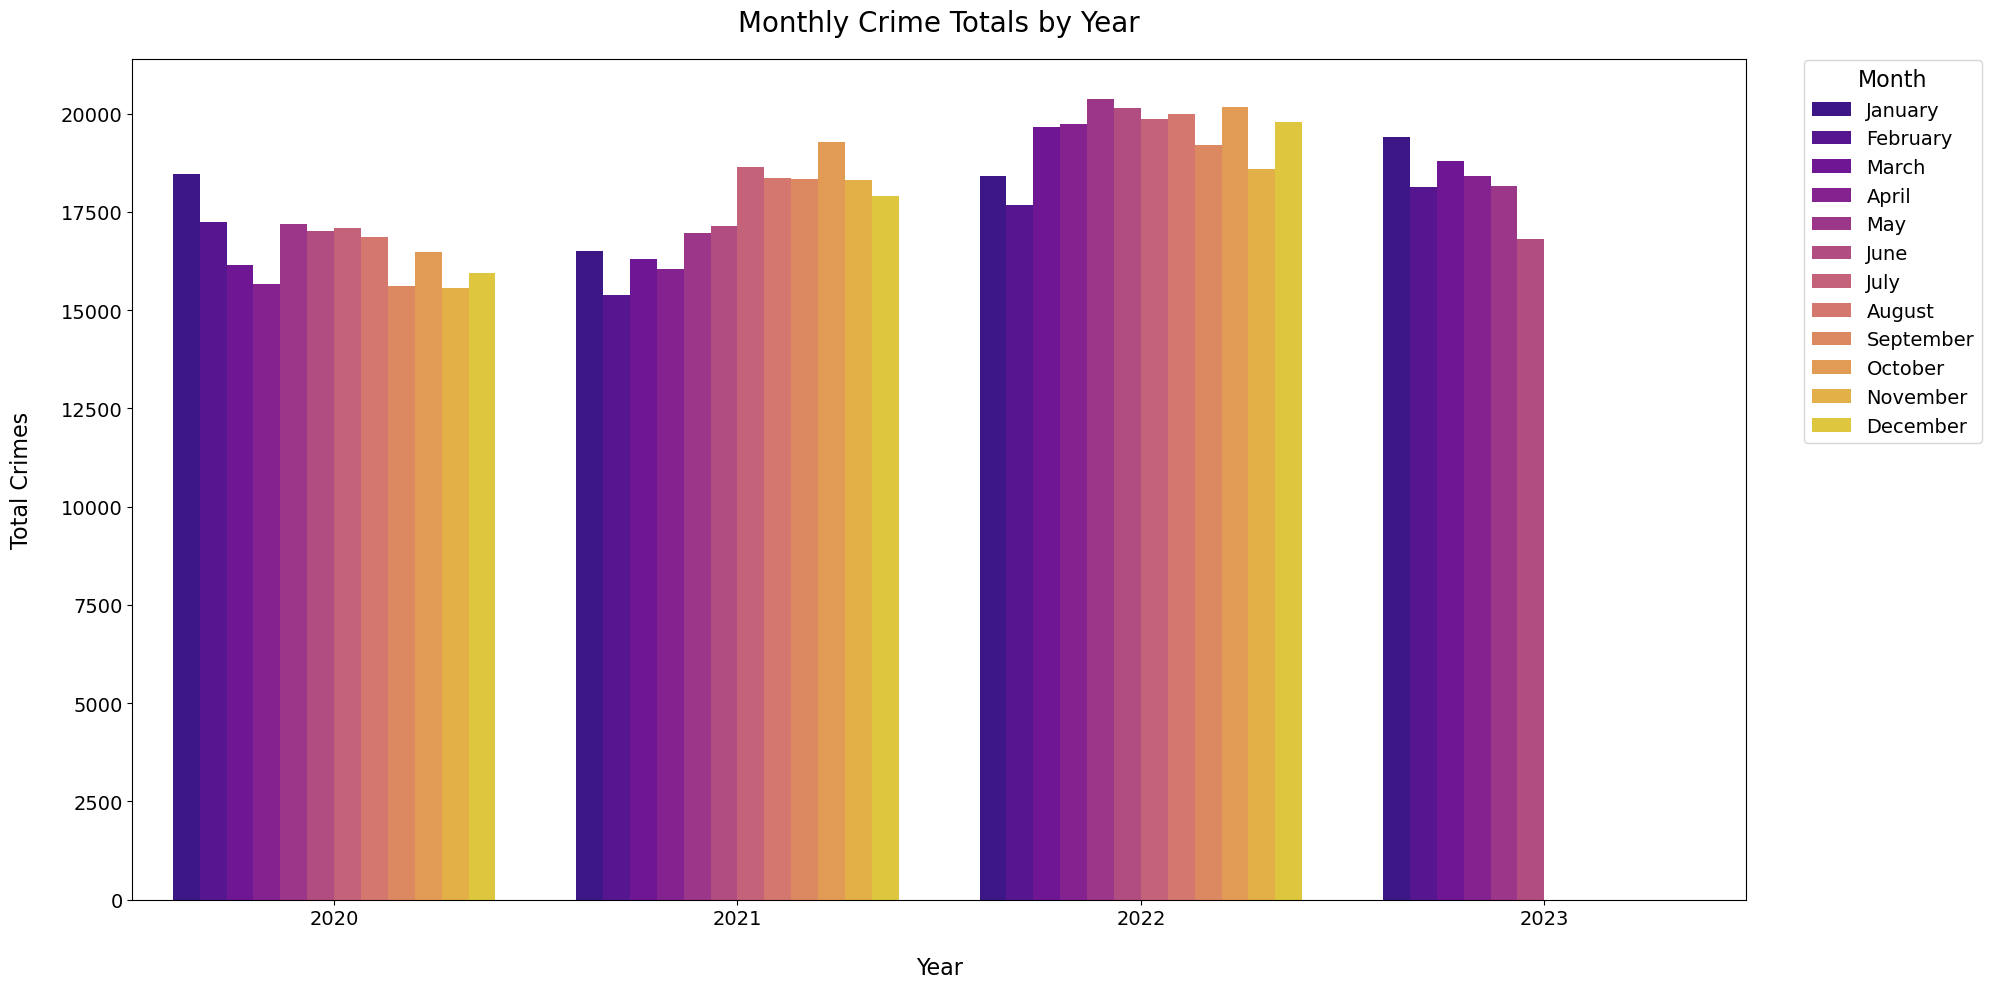

In [5]:
# plotting
# plasma palette as it basically represents the lakers colors
plt.figure(figsize=(20, 10))
sns.barplot(data=monthly_crime, y='count', x='year', hue='month', palette='plasma')
plt.title('Monthly Crime Totals by Year', fontsize=20, pad=20)
plt.xlabel('Year', fontsize=16, labelpad=20)
plt.ylabel('Total Crimes', fontsize=16, labelpad=20)
plt.legend(title='Month', bbox_to_anchor=(1.03, 1.01), loc='upper left', fontsize='14', title_fontsize='16')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.tight_layout()
plt.show()

#### Average Monthly Crime Totals
This section visualizes the average number of crimes per month from the beginning of 2020 until the end of 2022, excluding data points from 2023, as they only extend to the middle of the year.

In [6]:
# creating a new dataframe with the 2023 entries filtered out
# group the data by month and calculate the mean crime count for each month
# reset index to turn month index back to a column
monthly_crime_pre_2023 = (monthly_crime_copy[monthly_crime_copy.year != 2023])
average_monthly_crime = monthly_crime_pre_2023.groupby('month').mean().round(decimals=1)
average_monthly_crime = average_monthly_crime.drop('year', axis=1)
average_monthly_crime = average_monthly_crime.reset_index()
average_monthly_crime['month'] = month_names
print(average_monthly_crime.head())

      month    count
0   January  17792.3
1  February  16770.0
2     March  17373.3
3     April  17153.7
4       May  18181.3


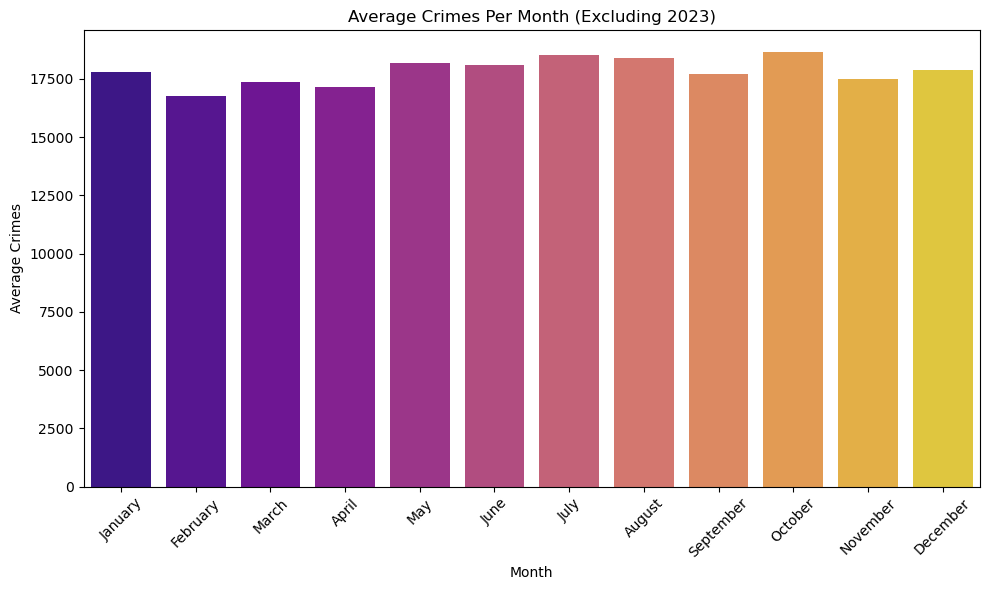

In [7]:
# plotting
plt.figure(figsize=(10, 6))  
sns.barplot(data=average_monthly_crime, x='month', y='count', palette='plasma')
plt.title('Average Crimes Per Month (Excluding 2023)')
plt.xlabel('Month')
plt.ylabel('Average Crimes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

#### Average Daily Crimes by Day of the Week

In [8]:
# giving each row a date of the week based on their date in date_occured
# counting the amount of crime that occured on each weekday and store them in the crime_weekday series
df['day_of_week'] = df['date_occurred'].dt.day_name()
crime_weekday_total = df.groupby(['day_of_week']).size()


# removing date duplicates and counting how many individual occurrences of a weekday there are
weekday_count = df.drop_duplicates(subset=['date_occurred'])
weekday_count = weekday_count.groupby(['day_of_week']).size()


# concatenating the two series into one dataframe
# renaming the column headers
# reset index to convert the weekday into a regular column
average_crime_weekday = pd.concat([crime_weekday_total, weekday_count], axis=1)
average_crime_weekday.columns = ['total_crimes', 'unique_days']
average_crime_weekday = average_crime_weekday.reset_index()
average_crime_weekday['average'] = average_crime_weekday['total_crimes'] / average_crime_weekday['unique_days']


# sort the dataframe by the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_crime_weekday['day_of_week'] = pd.Categorical(average_crime_weekday['day_of_week'], categories=day_order, ordered=True)
average_crime_weekday = average_crime_weekday.sort_values('day_of_week')
average_crime_weekday = average_crime_weekday.reset_index(drop=True)


print(average_crime_weekday)

  day_of_week  total_crimes  unique_days     average
0      Monday        106717          183  583.153005
1     Tuesday        103191          182  566.983516
2   Wednesday        107125          183  585.382514
3    Thursday        106230          183  580.491803
4      Friday        114875          183  627.732240
5    Saturday        109856          183  600.306011
6      Sunday        104917          183  573.316940


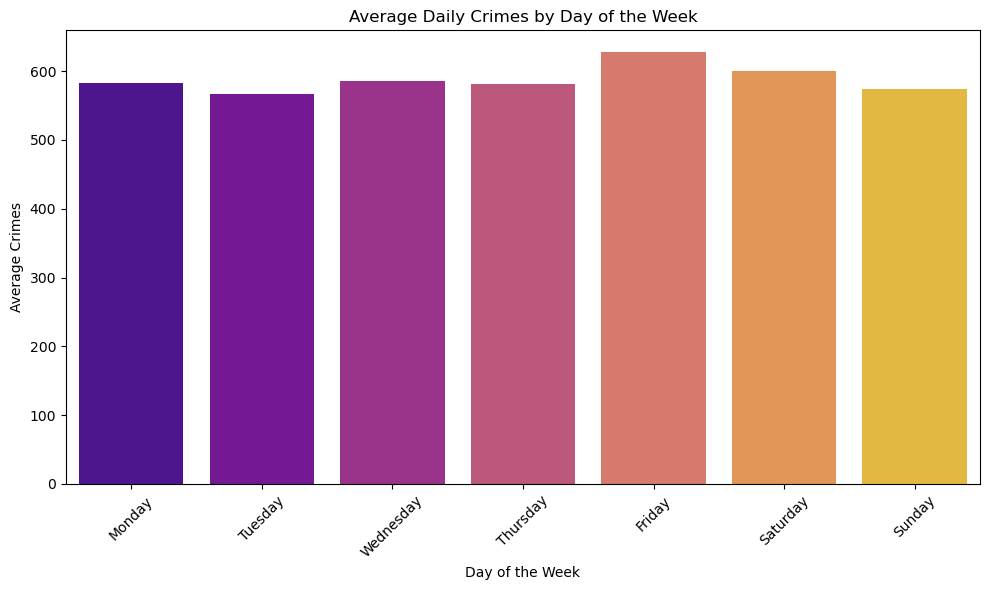

In [9]:
# plotting
plt.figure(figsize=(10, 6))  
sns.barplot(data=average_crime_weekday, x='day_of_week', y='average', palette='plasma')
plt.title('Average Daily Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Crimes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

#### Total Crime Counts by Hour of the Day

In [10]:
# converting the time_occurred column to a string that can be manipulated
df['time_occurred'] = df['time_occurred'].astype(str)


formatted_times = []

for i in df['time_occurred']:
    difference = 4 - len(i) # calculate numbers of zeros missing to make time four digits long
    i = (difference * '0') + i # get the necessary number of zeros to each time string
    i = i[:2] + ':' + i[2:] # format the string in a way that it can be converted into a datetime object
    formatted_times.append(i) # append the formatted time string to the list


# replace the original time_occurred column with the new formatted times
df['time_occurred'] = formatted_times
#print(df['time_occurred'].head())
print(df.head())

  date_occurred time_occurred  area_id    area_name  crime_code  \
0    2020-01-08         22:30        3    Southwest         624   
1    2020-01-01         03:30        1      Central         624   
2    2020-02-13         12:00        1      Central         845   
3    2020-01-01         17:30       15  N Hollywood         745   
4    2020-01-01         04:15       19      Mission         740   

                                   crime_description  victim_age victim_sex  \
0                           BATTERY - SIMPLE ASSAULT          36          F   
1                           BATTERY - SIMPLE ASSAULT          25          M   
2          SEX OFFENDER REGISTRANT OUT OF COMPLIANCE           0          X   
3           VANDALISM - MISDEAMEANOR ($399 OR UNDER)          76          F   
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...          31          X   

  victim_descent  latitude  longitude day_of_week  
0              B   34.0141  -118.2978   Wednesday  
1              H  

In [11]:
# convert time_occurred column to datetime objects
# group the data by one hour intervals
# reset index to convert the time_occurred into a regular column
df['time_occurred'] = pd.to_datetime(df['time_occurred'])
hourly_crime = df.groupby(pd.Grouper(key='time_occurred', freq='60T')).size()
hourly_crime = hourly_crime.reset_index()

# alter strings and headers for more clarity
hourly_crime['time_occurred'] = hourly_crime['time_occurred'].astype(str)
hourly_crime['time_occurred'] = hourly_crime['time_occurred'].str[11:16]
hourly_crime.columns = ['time_occurred', 'crime_count']


print(hourly_crime.head())

C:\Windows\Temp\ipykernel_8584\633399328.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_occurred'] = pd.to_datetime(df['time_occurred'])


  time_occurred  crime_count
0         00:00        31232
1         01:00        22794
2         02:00        19305
3         03:00        16825
4         04:00        14188


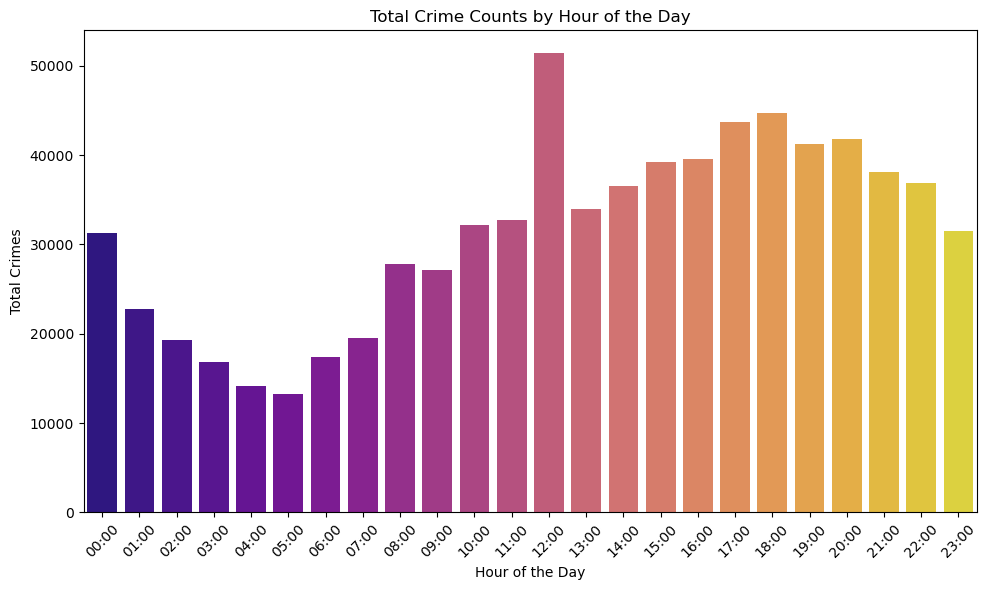

In [12]:
# plotting
plt.figure(figsize=(10, 6))  
sns.barplot(data=hourly_crime, x='time_occurred', y='crime_count', palette='plasma')
plt.title('Total Crime Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Crimes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

### 3.2 Crime versus Area
The LAPD is divided into 21 precincts. To better visualize the area of jurisdiction for each precinct, their borders are included using a GeoJSON dataset.<br>
<br>
[LAPD presincts data](https://geohub.lacity.org/datasets/lahub::lapd-divisions/explore?location=34.017393%2C-118.410104%2C9.90)

In [13]:
# interactive plot in dem man timeframe, victim, gender und ethnicity wählen kann aber wsl als letztes
crime_by_area = df.groupby('area_name').size()
crime_by_area = crime_by_area.reset_index()
crime_by_area.columns = ['area_name', 'crime_count']
crime_by_area = crime_by_area.sort_values(by='crime_count', ascending=False, kind='quicksort')
crime_by_area = crime_by_area.reset_index(drop=True)
print(crime_by_area.head())

     area_name  crime_count
0      Central        50499
1  77th Street        47682
2      Pacific        43880
3    Southwest        42061
4    Hollywood        40184


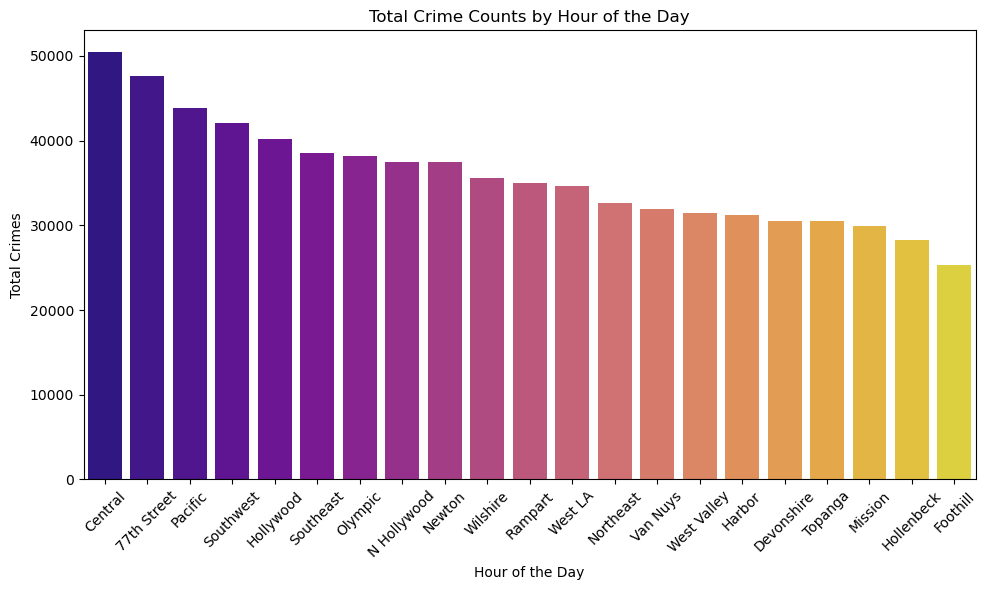

In [14]:
# plotting
plt.figure(figsize=(10, 6))  
sns.barplot(data=crime_by_area, x='area_name', y='crime_count', palette='plasma')
plt.title('Total Crime Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Crimes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [15]:
# import geojson data and display first 5 rows
lapd_jurisdiction = gpd.read_file('../data/LAPD_Division.geojson')
print(lapd_jurisdiction.head())

   OBJECTID        APREC  PREC          AREA      PERIMETER  \
0         1      MISSION    19  6.995826e+08  190817.495739   
1         2   DEVONSHIRE    17  1.346816e+09  175591.702871   
2         3     FOOTHILL    16  1.297385e+09  203717.879169   
3         4      TOPANGA    21  9.090326e+08  155505.795458   
4         5  WEST VALLEY    10  9.364057e+08  136316.899694   

                                            geometry  
0  POLYGON ((6408504.431 1944548.806, 6409580.000...  
1  POLYGON ((6408504.431 1944548.806, 6408709.000...  
2  POLYGON ((6436082.000 1929575.125, 6436122.235...  
3  POLYGON ((6370761.344 1909803.646, 6370805.000...  
4  POLYGON ((6391688.000 1903046.000, 6391826.000...  


In [16]:
# Latitude and longitude of Los Angeles
la_latitude = 34.012235
la_longitude = -118.361285

# Create a map of Los Angeles using CartoDB Positron tiles, without zoom controls
la_map = folium.Map(location=[la_latitude, la_longitude], 
                    zoom_start=10, 
                    zoom_control=False, 
                    tiles='CartoDB positron',
                    dragging=False,
                    scrollWheelZoom=False,
                    doubleClickZoom=False,
                    boxZoom=False,
                    touchZoom=False,
                    keyboard=False)


# Define a style function for the GeoJSON layer to make borders thinner and fill area transparent
def style_function(feature):
    return {
        'fillColor': None,  # No fill color
        'color': 'black',  # Border color
        'weight': 1,  # Border thickness
        'fillOpacity': 0  # No fill opacity
    }

# Add the GeoJSON layer with the defined style to the map
folium.GeoJson(
    lapd_jurisdiction,
    name='LAPD Jurisdiction',
    style_function=style_function
).add_to(la_map)

# Adjusted heatmap settings to be less sensitive
heatmap_data = list(map(list, zip(df['latitude'], df['longitude'])))
HeatMap(heatmap_data, radius=28, blur=10, max_zoom=1, min_opacity=0.2).add_to(la_map)

Due to GitHub's issues with displaying the original output, a picture of the heatmap is inserted instead
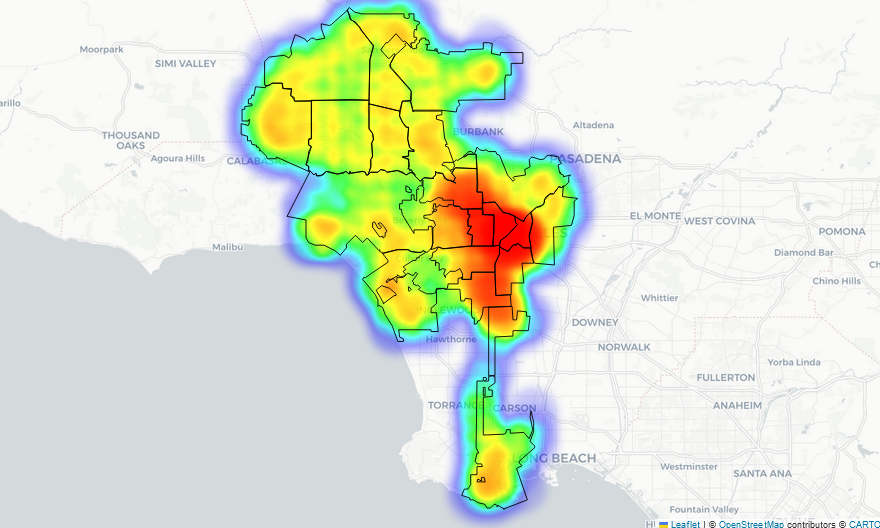

In [17]:
#la_map